In [1]:
# import h5py
import numpy as np
import pandas as pd
#import gdal
import matplotlib
import matplotlib.pyplot as plt
import IPython.display 
from PIL import Image

%matplotlib inline 

from scipy.stats import pearsonr

import spectral.io.envi as envi

In [3]:
img = envi.open('Data/Ex1.hdr', 'Data/Ex1.img')

In [4]:
img

	Data Source:   './Data/Ex1.img'
	# Rows:           4060
	# Samples:         275
	# Bands:           285
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32

There are 285 slices of 4060 x 275 images. Each slice corresponds to a wavelength.

In [5]:
pixel_x = range(0,img.shape[0])[0]
pixel_y = range(0,img.shape[1])[0]

In [6]:
wavelength = img.bands.centers
reflectance = img.read_pixel(pixel_x,pixel_y)

In [7]:
good_wavelengths_mask = [x for x in range(0,len(wavelength)) if wavelength[x] > 1000 and wavelength[x] < 2400]

In [8]:
wavelength = [wavelength[x] for x in good_wavelengths_mask]
reflectance = [reflectance[x] for x in good_wavelengths_mask]

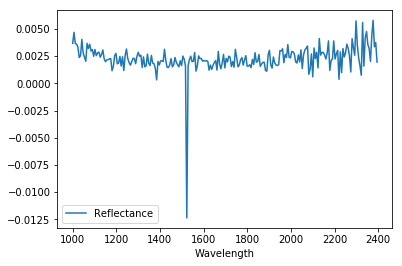

In [14]:
df_plot = pd.DataFrame(wavelength,reflectance).reset_index()
df_plot.columns = ['Reflectance','Wavelength']
df_plot.set_index('Wavelength',inplace=True)
df_plot.plot()

## Pick 20 random samples: 4 from each image

Pixel (633,160) from Data/Ex1.img


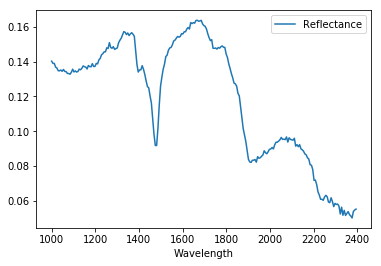

Pixel (377,114) from Data/Ex1.img


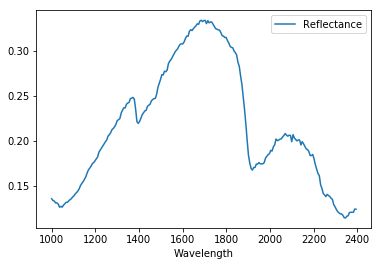

Pixel (3083,98) from Data/Ex1.img


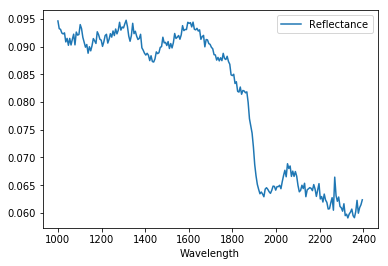

Pixel (2235,211) from Data/Ex1.img


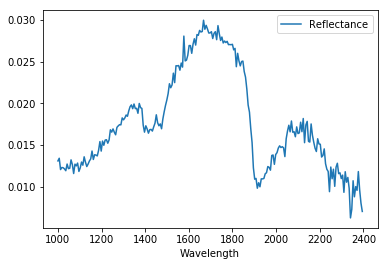

Pixel (449,129) from Data/Ex1.img


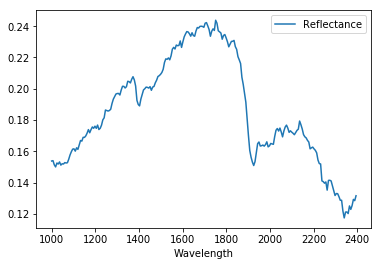

Pixel (591,300) from Data/Ex2.img


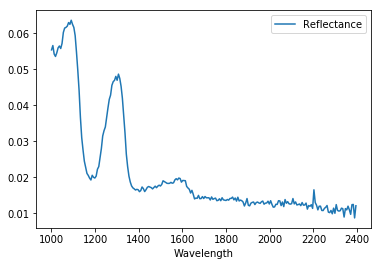

Pixel (1954,178) from Data/Ex2.img


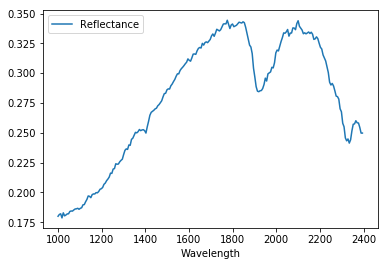

Pixel (3446,99) from Data/Ex2.img


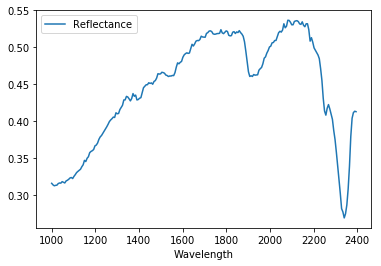

Pixel (781,80) from Data/Ex2.img


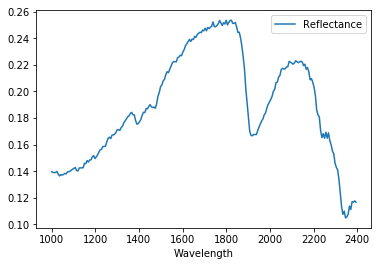

Pixel (1769,33) from Data/Ex2.img


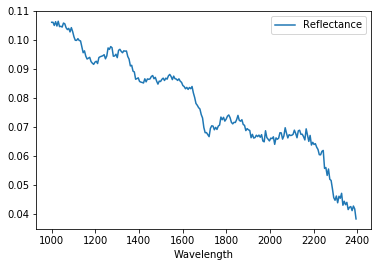

Pixel (1612,143) from Data/Ex3.img


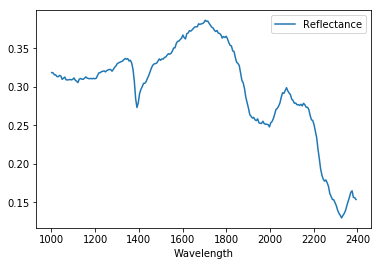

Pixel (1301,181) from Data/Ex3.img


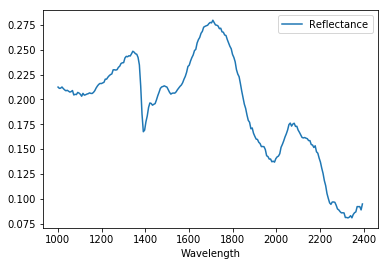

Pixel (1497,100) from Data/Ex3.img


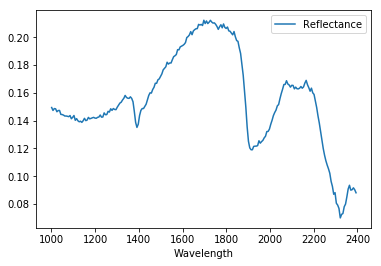

Pixel (2093,154) from Data/Ex3.img


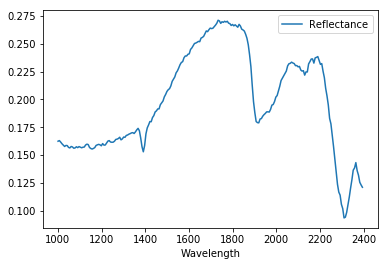

Pixel (2681,135) from Data/Ex3.img


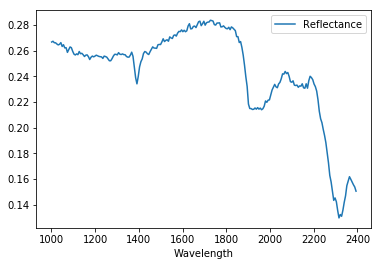

Pixel (1064,282) from Data/Ex4.img


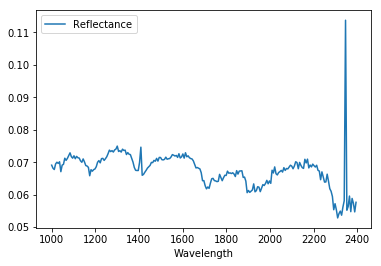

Pixel (2510,180) from Data/Ex4.img


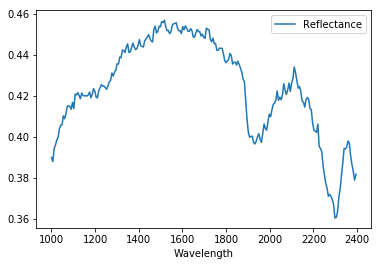

Pixel (224,310) from Data/Ex4.img


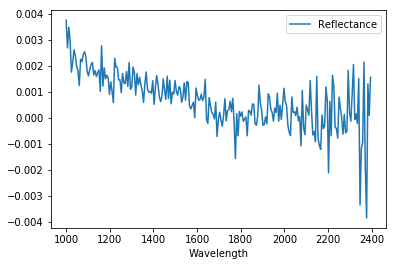

Pixel (1719,222) from Data/Ex4.img


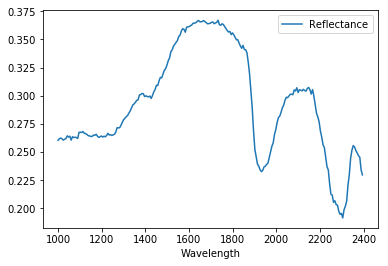

Pixel (3081,235) from Data/Ex4.img


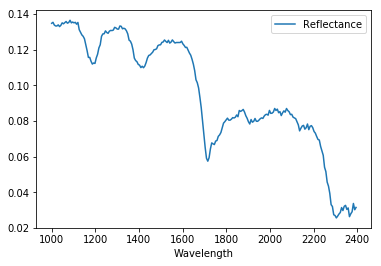

Pixel (1724,68) from Data/Ex5.img


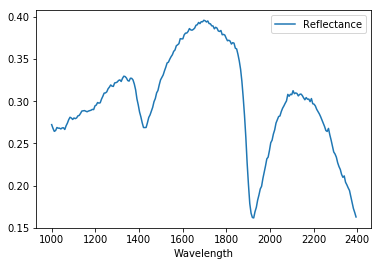

Pixel (2823,150) from Data/Ex5.img


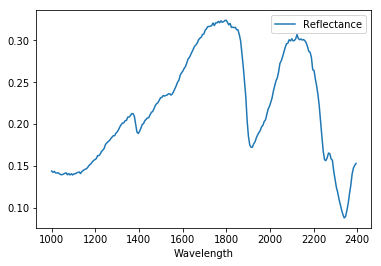

Pixel (1614,200) from Data/Ex5.img


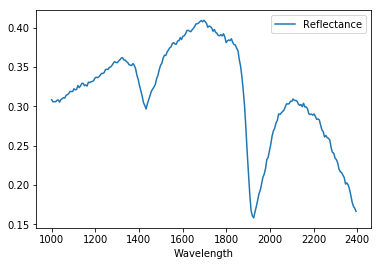

Pixel (3490,308) from Data/Ex5.img


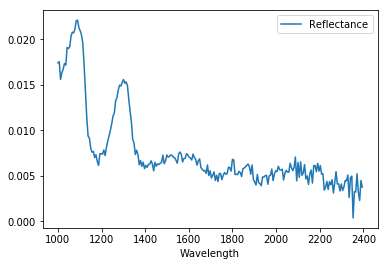

Pixel (2177,173) from Data/Ex5.img


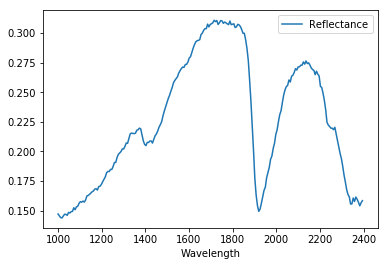

In [53]:
for img_number in range(1,6):
    img = envi.open('Data/Ex' + str(img_number) + '.hdr', 'Data/Ex' + str(img_number) + '.img')

    for counter in range(0,5):
        random_pixel_x = np.random.randint(0,img.shape[0])
        random_pixel_y = np.random.randint(0,img.shape[1])

        wavelength = img.bands.centers
        reflectance = img.read_pixel(random_pixel_x,random_pixel_y)

        good_wavelengths_mask = [x for x in range(0,len(wavelength)) if wavelength[x] > 1000 and wavelength[x] < 2400]

        wavelength = [wavelength[x] for x in good_wavelengths_mask]
        reflectance = [reflectance[x] for x in good_wavelengths_mask]

        print("Pixel (" + str(random_pixel_x) + "," + str(random_pixel_y) + ") from " + 'Data/Ex' + str(img_number) + '.img')
        df_plot = pd.DataFrame(wavelength,reflectance).reset_index()
        df_plot.columns = ['Reflectance','Wavelength']
        df_plot.set_index('Wavelength',inplace=True)
        df_plot.plot()
        plt.show()

## Anomaly detection idea: spectrum crossing its moving average

In [50]:
df_plot['rolling'] = df_plot['Reflectance'].rolling(30).mean()

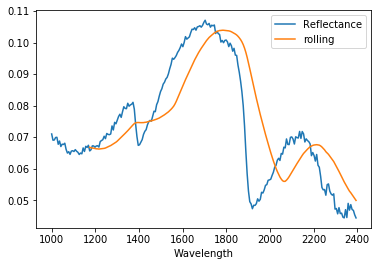

In [51]:
df_plot.plot()

## Get pure mineral spectra

In [56]:
img = envi.open('Data/usgs_min.hdr', 'Data/usgs_min.sli')
spectra = pd.DataFrame(img.spectra, index=img.names, columns=[x*1000 for x in img.bands.centers]).T
spectra = spectra[(spectra.index > 1000) & (spectra.index < 2400)]

In [151]:
spectra.shape

(201, 481)

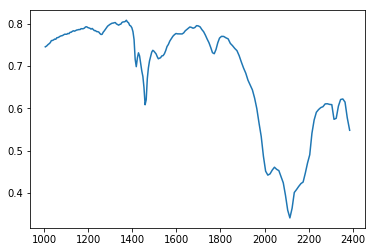

In [152]:
spectra.iloc[:,0].plot()

## Normalize + Derivitize + Smooth

Normalize between 0 and 1

Smooth use Savitsky-Golay filter with 25-point + 4th order polynomial (Ishikawa and Gulick 2012)

Derivitize by taking difference

In [153]:
def normalize(series):
    return (series - series.min())/(series.max() - series.min())

def derivitize(series):
    return series.pct_change()

def savgol(series):
    return scipy.signal.savgol_filter(series.values,25,4)

def process(series):
    return series.apply(normalize).apply(savgol).values

In [158]:
spectrum = spectra.iloc[:,[0]]
spectrum.columns = ['Original Spectrum']

In [159]:
spectrum['normalized'] = spectrum[['Original Spectrum']].apply(normalize).values
spectrum['savgol'] = spectrum[['Original Spectrum']].apply(savgol).values
spectrum['normalized_savgol'] = spectrum[['Original Spectrum']].apply(normalize).apply(savgol).values
spectrum['savgol_normalized'] = spectrum[['Original Spectrum']].apply(savgol).apply(normalize).values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

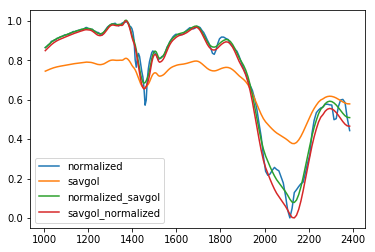

In [160]:
spectrum.iloc[:,1:].plot()

In [161]:
spectrum['processed'] = process(spectrum[['Original Spectrum']])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Try simple correlation-based approach

In [174]:
def get_spectrum_from_img(img_number, pixel_x, pixel_y):

    img = envi.open('Data/Ex' + str(img_number) + '.hdr', 'Data/Ex' + str(img_number) + '.img')

    wavelength = img.bands.centers
    reflectance = img.read_pixel(pixel_x, pixel_y)

    good_wavelengths_mask = [x for x in range(0,len(wavelength)) if wavelength[x] > 1000 and wavelength[x] < 2400]

    wavelength = [wavelength[x] for x in good_wavelengths_mask]
    reflectance = [reflectance[x] for x in good_wavelengths_mask]

    df_raw = pd.DataFrame(wavelength,reflectance).reset_index()
    df_raw.columns = ['Reflectance','Wavelength']
    df_raw.set_index('Wavelength',inplace=True)
    df_raw['Reflectance'] = process(df_raw[['Reflectance']])
    
    return df_raw

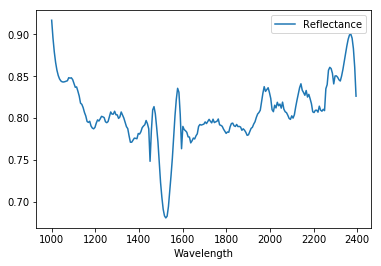

In [175]:
img_number = 1
pixel_x = 0
pixel_y = 0
spectrum = get_spectrum_from_img(1,0,0)
spectrum.plot()

In [211]:
spectrum

,Reflectance
Wavelength,
1000.369995,0.916911
1006.380005,0.895612
1012.390015,0.879022
1018.400024,0.866454
1024.400024,0.857270
1030.410034,0.850879
1036.420044,0.846736
1042.430054,0.844344
1048.439941,0.843254


### Build library of existing minerals

In [380]:
def get_pure_spectra_library():
    img = envi.open('Data/usgs_min.hdr', 'Data/usgs_min.sli')
    spectra = pd.DataFrame(img.spectra, index=img.names, columns=[x*1000 for x in img.bands.centers]).T
    spectra = spectra[(spectra.index > 1000) & (spectra.index < 2540)]
    for column in spectra.columns:
        spectra[column] = spectra[[column]].apply(normalize).apply(savgol).values
    return spectra

### Look at correlation

In [227]:
spectrum = get_spectrum_from_img(1,0,0)

/usr/local/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [231]:
basic_index = pd.DataFrame(index=range(1000,2540))
spectrum.index = [round(x) for x in spectrum.index]
spectra.index = [round(x) for x in spectra.index]

corr_dict = {}
for column in range(0,spectra.shape[1]):
    joined = pd.concat([basic_index,spectrum.iloc[:,0],spectra.iloc[:,column]],axis=1).interpolate().bfill()
    corr = joined.corr().values[0,1]
    corr_dict[spectra.columns[column]] = corr

results_df = pd.DataFrame([corr_dict.keys(),corr_dict.values()]).T
results_df.columns = ['Mineral','Corr']
results_df = results_df.sort_values('Corr',ascending=False)

pd.concat([basic_index,spectrum.iloc[:,0],spectra.loc[:,results_df['Mineral'][:5].values]],axis=1).interpolate().bfill() \
    .plot(figsize=(10,4))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
plt.show()

In [340]:
x = [int(x.split(",")[0]) for x in text.replace("\n","").split("Pixel (")[1:]]

In [341]:
y = [int(x.split(",")[1].split(")")[0]) for x in text.replace("\n","").split("Pixel (")[1:]]

In [366]:
z = [int(x.split(".")[0]) for x in text.replace("\n","").split("Ex")[1:]]

In [367]:
sample_pixels = [x for x in zip(x,y,z)]

In [368]:
print(sample_pixels)

[(633, 160, 1), (377, 114, 1), (3083, 98, 1), (2235, 211, 1), (449, 129, 1), (591, 300, 2), (1954, 178, 2), (3446, 99, 2), (781, 80, 2), (1769, 33, 2), (1612, 143, 3), (1301, 181, 3), (1497, 100, 3), (2093, 154, 3), (2681, 135, 3), (1064, 282, 4), (2510, 180, 4), (224, 310, 4), (1719, 222, 4), (3081, 235, 4), (1724, 68, 5), (2823, 150, 5), (1614, 200, 5), (3490, 308, 5), (2177, 173, 5)]


In [369]:
sample_pixels = [(633, 160, 1), (377, 114, 1), (3083, 98, 1), (2235, 211, 1), (449, 129, 1), (591, 300, 2), (1954, 178, 2), (3446, 99, 2), (781, 80, 2), (1769, 33, 2), (1612, 143, 3), (1301, 181, 3), (1497, 100, 3), (2093, 154, 3), (2681, 135, 3), (1064, 282, 4), (2510, 180, 4), (224, 310, 4), (1719, 222, 4), (3081, 235, 4), (1724, 68, 5), (2823, 150, 5), (1614, 200, 5), (3490, 308, 5), (2177, 173, 5)]

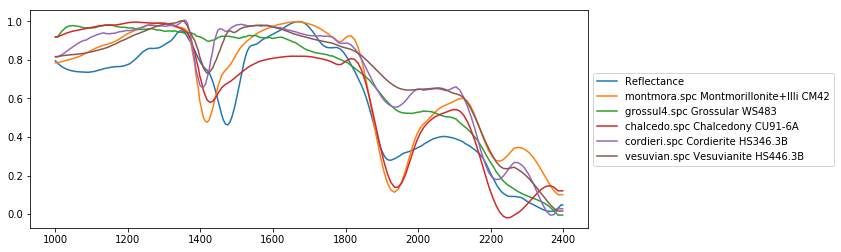

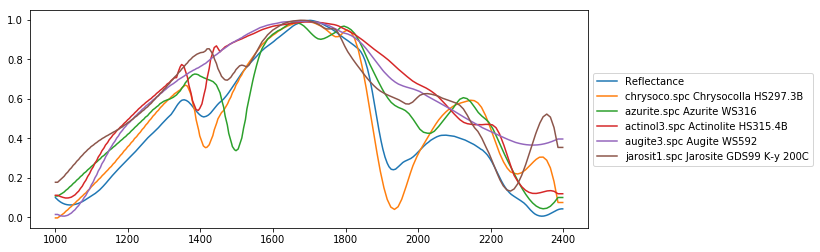

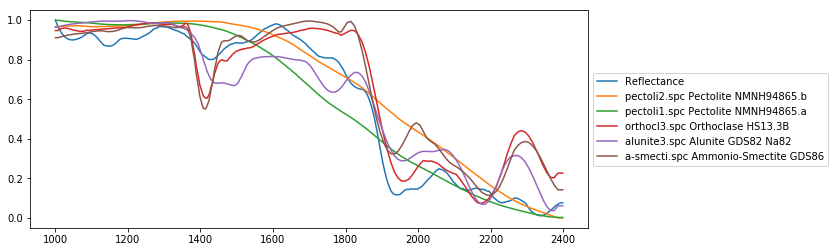

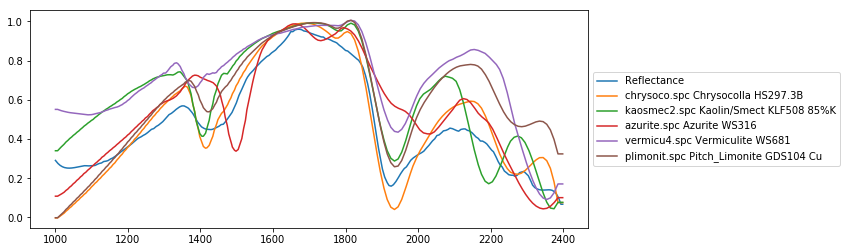

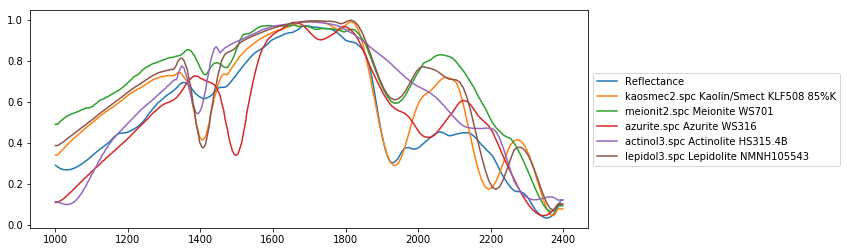

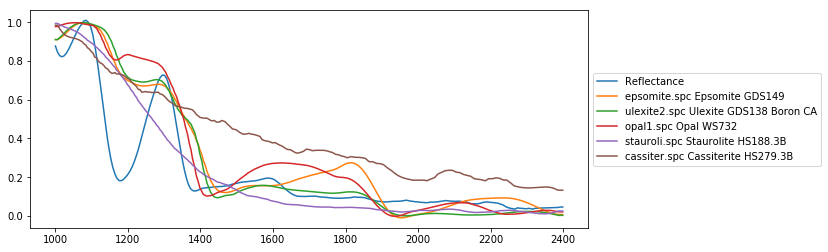

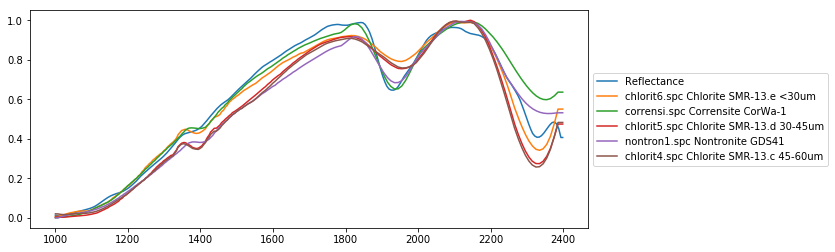

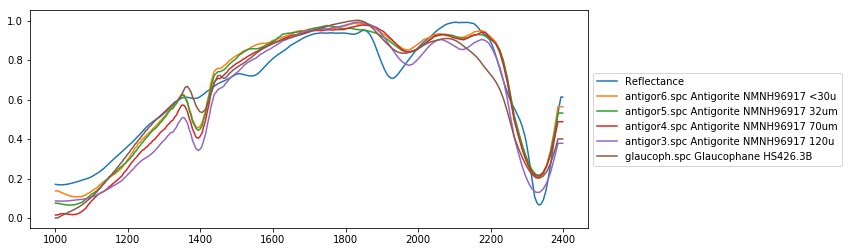

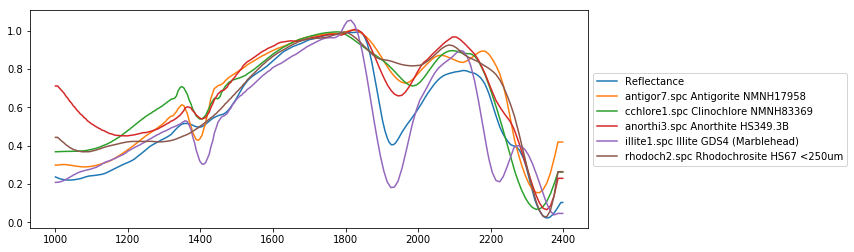

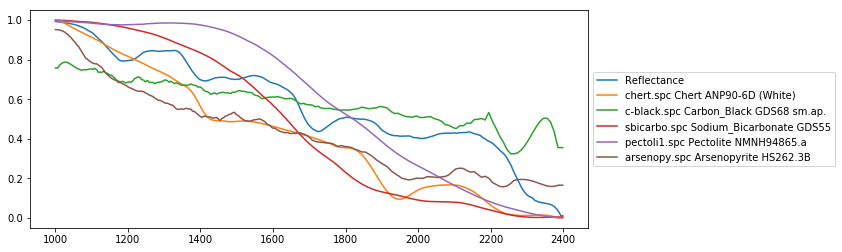

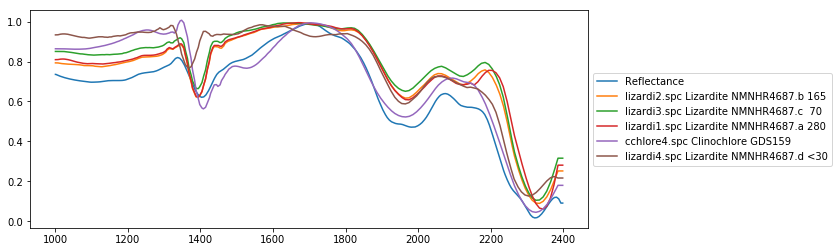

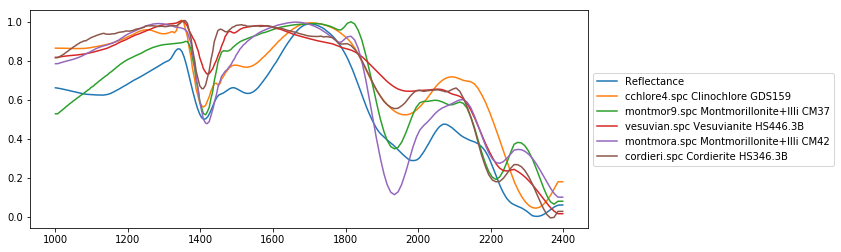

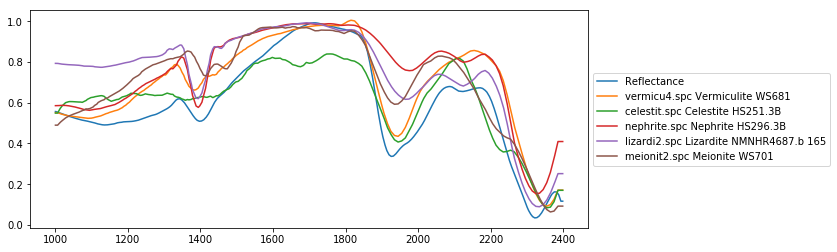

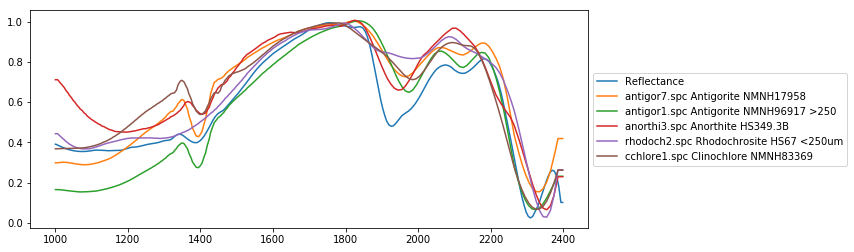

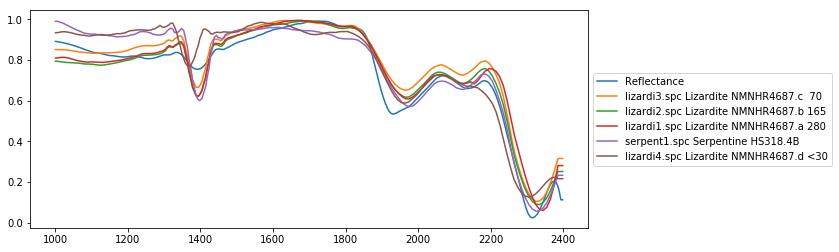

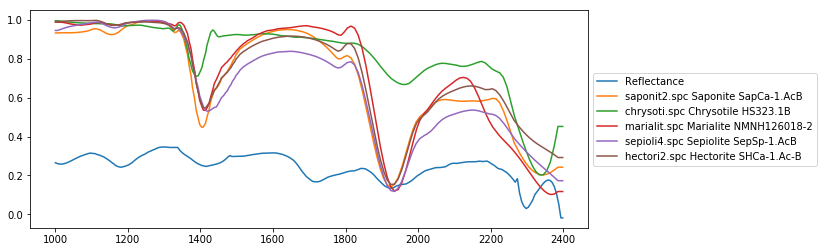

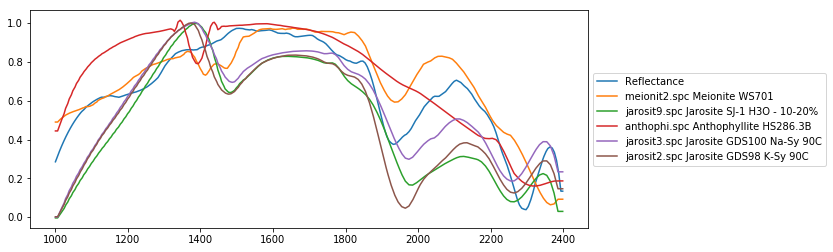

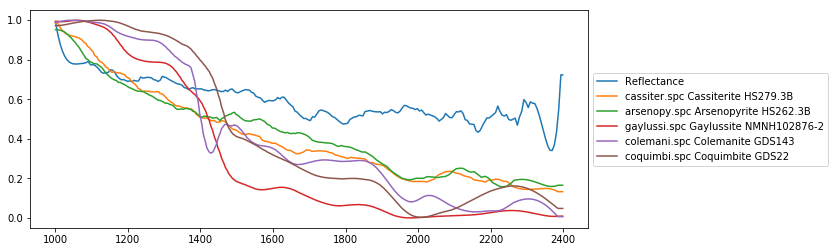

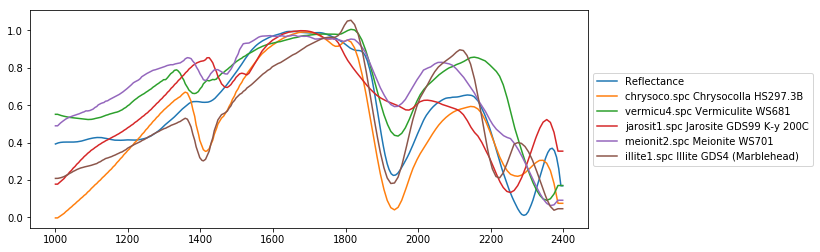

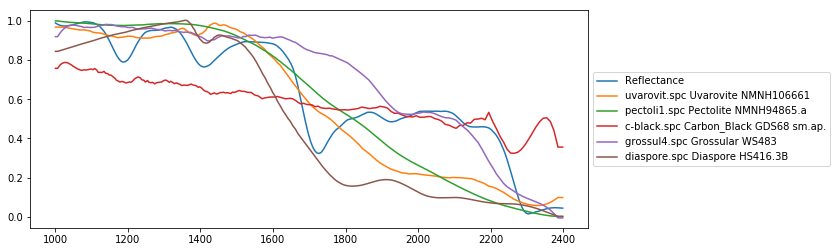

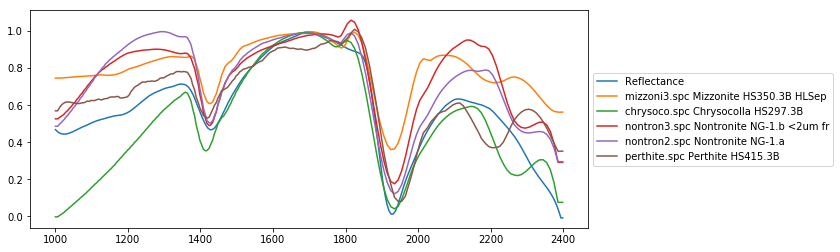

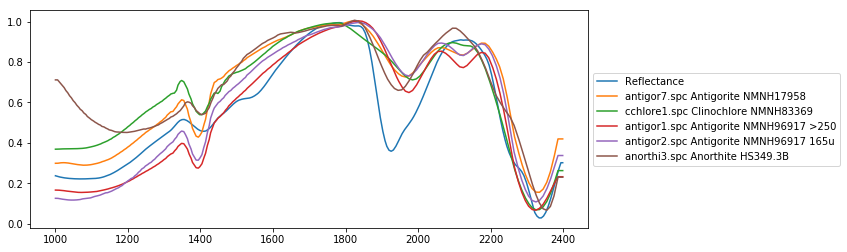

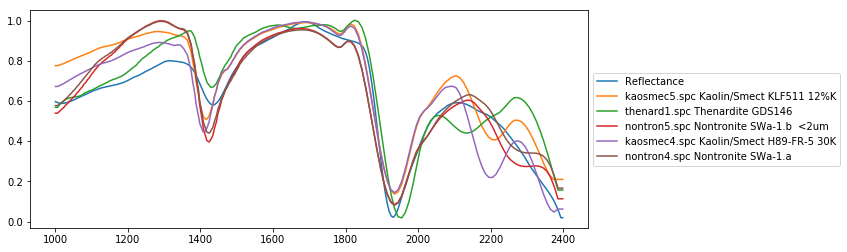

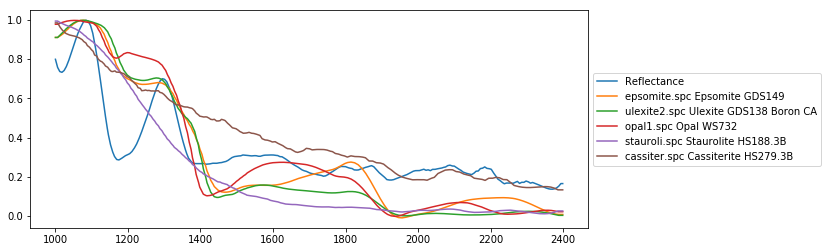

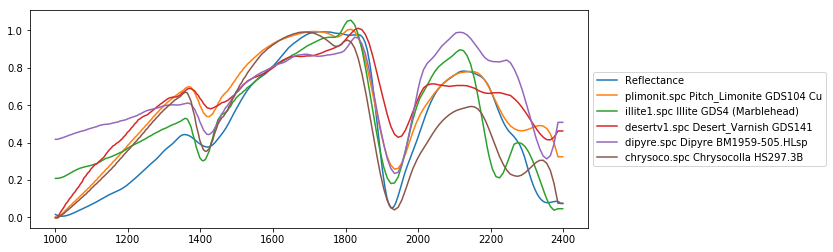

In [371]:
for pixel_pair in sample_pixels:
    spectrum = get_spectrum_from_img(pixel_pair[2],pixel_pair[0],pixel_pair[1])
    
    basic_index = pd.DataFrame(index=range(1000,2400))
    spectrum.index = [round(x) for x in spectrum.index]
    spectra.index = [round(x) for x in spectra.index]

    corr_dict = {}
    for column in range(0,spectra.shape[1]):
        joined = pd.concat([basic_index,spectrum.iloc[:,0],spectra.iloc[:,column]],axis=1).interpolate().bfill()
        corr = joined.corr().values[0,1]
        corr_dict[spectra.columns[column]] = corr

    results_df = pd.DataFrame([corr_dict.keys(),corr_dict.values()]).T
    results_df.columns = ['Mineral','Corr']
    results_df = results_df.sort_values('Corr',ascending=False)

    pd.concat([basic_index,spectrum.iloc[:,0],spectra.loc[:,results_df['Mineral'][:5].values]],axis=1).interpolate().bfill() \
        .plot(figsize=(10,4))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()
    plt.show()

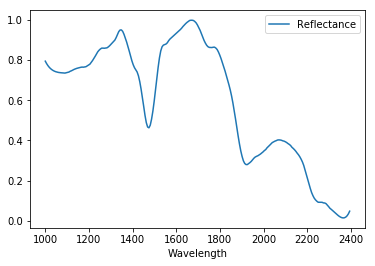

In [351]:
pixel_pair = sample_pixels[0]
get_spectrum_from_img(1,pixel_pair[0],pixel_pair[1]).plot()

## Build script to return ranked vector of minerals + corr for a pixel

In [384]:
def get_spectrum_from_img(img, pixel_x, pixel_y):

    wavelength = img.bands.centers
    reflectance = img.read_pixel(pixel_x, pixel_y)

    good_wavelengths_mask = [x for x in range(0,len(wavelength)) if wavelength[x] > 1000 and wavelength[x] < 2400]

    wavelength = [wavelength[x] for x in good_wavelengths_mask]
    reflectance = [reflectance[x] for x in good_wavelengths_mask]

    df_raw = pd.DataFrame(wavelength,reflectance).reset_index()
    df_raw.columns = ['Reflectance','Wavelength']
    df_raw.set_index('Wavelength',inplace=True)
    df_raw['Reflectance'] = process(df_raw[['Reflectance']])
    
    return df_raw

In [417]:
img.read_pixel(0,0)

array([ 0.04833515,  0.02568781,  0.04591275,  0.02640352,  0.0278378 ,
        0.01933496,  0.01964594,  0.01128483,  0.00819674,  0.009301  ,
        0.00767578,  0.00642099,  0.00414541,  0.00317495,  0.00397048,
        0.0046081 ,  0.00416152,  0.00366987,  0.00468458,  0.00365934,
        0.00360041,  0.00333719,  0.00237382,  0.00252852,  0.0040494 ,
        0.00278777,  0.00241696,  0.00202637,  0.0036713 ,  0.00319915,
        0.00359013,  0.00296052,  0.00310824,  0.00248565,  0.00310909,
        0.00254683,  0.00278548,  0.0028706 ,  0.00240007,  0.00264025,
        0.0030673 ,  0.00225908,  0.00198182,  0.00215444,  0.0021771 ,
        0.00225178,  0.00227877,  0.00115674,  0.00152762,  0.00253521,
        0.00275216,  0.00179871,  0.00185175,  0.0024721 ,  0.00158703,
        0.00244185,  0.00117392,  0.00255347,  0.00315564,  0.0022775 ,
        0.00191827,  0.00166778,  0.00198845,  0.00229432,  0.00228964,
        0.00180166,  0.00248231,  0.00285392,  0.00248291,  0.00

In [ ]:
get_

In [375]:
img.shape

(4060, 275, 285)

In [387]:
from tqdm import tqdm

In [427]:
good_wavelengths_mask[0]

17

In [428]:
good_wavelengths_mask[-1]

249

In [449]:
img[:,:,0].shape

(4060, 275, 1)

In [454]:
spectra = get_pure_spectra_library()

img_number = 1
hdr = 'Data/Ex' + str(img_number) + '.hdr'
img = 'Data/Ex' + str(img_number) + '.img'

img = envi.open(hdr, img)

x_pixel_range = range(0,img.shape[0])
y_pixel_range = range(0,img.shape[1])

pixel_classification_dict = {}

wavelength = img.bands.centers
good_wavelengths_mask = [x for x in range(0,len(wavelength)) if wavelength[x] > 1000 and wavelength[x] < 2400]
wavelength = [wavelength[x] for x in good_wavelengths_mask]

processed_data = {}

for x in tqdm(x_pixel_range):
    for y in y_pixel_range:
        
        reflectance = img.read_pixel(x, y)

        reflectance = reflectance[good_wavelengths_mask[0]:(good_wavelengths_mask[-1]+1)]
        reflectance = normalize(reflectance)
        reflectance = scipy.signal.savgol_filter(reflectance,25,4)
        
        processed_data[x,y] = reflectance

#         df_raw = pd.DataFrame(wavelength,reflectance).reset_index()
#         df_raw.columns = ['Reflectance','Wavelength']
#         df_raw.set_index('Wavelength',inplace=True)
#         df_raw['Reflectance'] = process(df_raw[['Reflectance']])

#         spectrum = df_raw

#         basic_index = pd.DataFrame(index=range(1000,2540))
#         spectrum.index = [round(x) for x in spectrum.index]
#         spectra.index = [round(x) for x in spectra.index]
        
#         pixel_classification_dict[x,y] = \
#                     pd.concat([basic_index,spectrum.iloc[:,0],spectra],axis=1).interpolate().bfill() \
#                 .corr()[['Reflectance']].sort_values('Reflectance',ascending=False)[1:]

/usr/local/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

















  0%|          | 0/4060 [00:00<?, ?it/s]
















  0%|          | 1/4060 [00:00<13:38,  4.96it/s]
















  0%|          | 2/4060 [00:00<13:54,  4.86it/s]
















  0%|          | 3/4060 [00:00<13:57,  4.84it/s]
















  0%|          | 4/4060 [00:00<14:06,  4.79it/s]
















  0%|          | 5/4060 [00:01<14:42,  4.59it/s]
















  0%|          | 6/4060 [00:01<14:41,  4.60it/s]
















  0%|          | 7/4060 [00:01<14:13,  4.75it/s]
















  0%|          | 8/4060 [00:01<13:29,  5.00it/s]
















  0%|          | 9/4060 [00:01<13:13,  5.10it/

KeyboardInterrupt: 

In [457]:
spectrum = pd.DataFrame(processed_data)
spectrum.index = wavelength

In [4]:
%%time
basic_index = pd.DataFrame(index=range(1000,2540))
spectrum.index = [round(x) for x in spectrum.index]
spectra.index = [round(x) for x in spectra.index]
joined_spectra = pd.concat([basic_index,spectrum,spectra],axis=1).interpolate().bfill()

spectra_cleaned = joined_spectra.iloc[:,:spectrum.shape[1]]
spectrum_cleaned = joined_spectra.iloc[:,spectrum.shape[1]:]

NameError: name 'pd' is not defined

In [2]:
joined_spectra.iloc[:,[0,range(spectrum_cleaned.shape[1],joined_spectra.shape[1])]]

NameError: name 'joined_spectra' is not defined

In [3]:
joined_spectra

NameError: name 'joined_spectra' is not defined